# Allen Graph for synthetic logs

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../../src")
import networkx as nx
from helpers import graph


## Allen Graph

I will stick to a given control flow, the first example given by 1970-Allen. Oldy but goody.

To easily define a flow I need the longest paths and the loop info. Note the 425 524 apparent redundancy, but it will be used later to generate the traces. 

In [2]:
# Allen Graph Data
L_serials=['12356', '12456', '12476']
L_loops  =['452', '524', '523', '53', '77']
L = L_serials + L_loops

In [3]:
Ag=nx.DiGraph()
for T in L:
    for u, v in zip(T[:-1], T[1:]):
        Ag.add_edge(u, v)

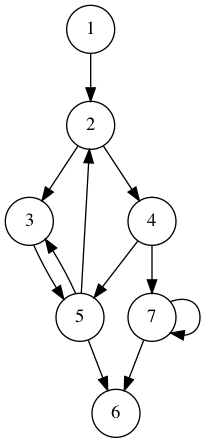

In [4]:
graph(Ag)

## Random traces from Allen Graph

The *Allen Log* is a set of *Allen Traces*, a trace that can replayed in an Allen graph. To write a trace I already have the longest paths, I assume that the head/tail are the start/end. I choose one arbitrary serial and make a walk following the each symbol $s$. But if $s$ overlaps with an arbitrary loop, I insert R repetitions jut before adding $s$. 

I stopped there, but to be really complete I should have had the "$s$ overlaps with an arbitrary loop" also inside the loops. For the sake of brevity, what I built is enough to have different traces.


Is it clear?

In [5]:
from random import *

def create_allen_trace(L_serials, L_loops, max_repetitions=4):
    arbitrary_serial = L_serials[randint(0, len(L_serials)-1)]
    
    walk = []
    for s in arbitrary_serial:
        
        loops = [ list(a) for a in L_loops if a[0] == s]
        if loops:
            arbitrary_loop = loops[randint(0, len(loops)-1)]
            walk += (arbitrary_loop * randint(1, max_repetitions) + [s])
        else:
            walk.append(s)
    return walk

def allen_log(N):
    L = []
    for i in range(N):
        T = "".join(create_allen_trace(L_serials, L_loops))
        L.append(T)
    return L

In [6]:
Alog=allen_log(30)

# First traces
Alog[:10]

['12352352356',
 '1235356',
 '12352356',
 '12452452456',
 '1245247777777776',
 '1245245245245353535356',
 '12352456',
 '12452452452452452352356',
 '1245247777777776',
 '1245247777777776']

All symbols in Allen Graph $A_G$ are in some element of $A_{log}$:

In [7]:
for s in Ag.nodes:
    s_in_any_T = any([ s in T for T in Alog ])
    print( "Is symbol '%s' in any T in Alog? : %s" % (s, s_in_any_T) )

Is symbol '1' in any T in Alog? : True
Is symbol '2' in any T in Alog? : True
Is symbol '3' in any T in Alog? : True
Is symbol '5' in any T in Alog? : True
Is symbol '6' in any T in Alog? : True
Is symbol '4' in any T in Alog? : True
Is symbol '7' in any T in Alog? : True


In my method with max_repetitions=4, The length is bounded one of the worst case path+loop is len( 12 r(452) 4 r(523) 5 6 ) = 29

In [8]:
sorted(Alog, key=lambda T: -len(T))[:5]

['12452452452452452352352356',
 '12452452452452452352356',
 '12452452452452477777776',
 '12452452452452477777776',
 '1245245245245353535356']

In [9]:
len("12452452452452452352352352356")

29

## Expanding basic blocks in Allen Graphs

Allen defines *basic blocks* in the same we define *paths* as any trace $T \in \Sigma^*$ where symbols are all different. Thus, we need to define a mapping between Allen nodes and paths.

In [10]:
path = {
    "1": "abc",
    "2": "efg",
    "3": "hij",
    "4": "klm",
    "5": "nop",
    "6": "qrs",
    "7": "tuv"
}

and for each Allen trace we apply the mapping, for example

In [11]:
T = Alog[0]
mapped_T = [ path[s] for s in T ]
T, mapped_T

('12352352356',
 ['abc', 'efg', 'hij', 'nop', 'efg', 'hij', 'nop', 'efg', 'hij', 'nop', 'qrs'])

The mapped_T will be converted in a single string, and applied to every Allen traces in log

In [12]:
mapped_Alog = []
for T in Alog:
    mapped_Alog.append( "".join([ path[s] for s in T ]) )
    
Alog[0], mapped_Alog[0]

('12352352356', 'abcefghijnopefghijnopefghijnopqrs')

## Test path_invariants

In [13]:
from path_invariants import *

In [14]:
by_loops = infer_paths_by_combining_loops(mapped_Alog)

In [15]:
by_graphs = infer_paths_by_adding_graphs(mapped_Alog)

In [16]:
by_loops

[(36, ['h', 'i', 'j']),
 (104, ['e', 'f', 'g']),
 (106, ['n', 'o', 'p']),
 (79, ['t', 'u', 'v']),
 (81, ['k', 'l', 'm']),
 (30, ['a', 'b', 'c', 'q', 'r', 's'])]

In [17]:
by_graphs

[(1285, ['t', 'u', 'v']),
 (1160, ['n', 'o', 'p']),
 (659, ['k', 'l', 'm']),
 (984, ['e', 'f', 'g']),
 (90, ['a', 'b', 'c', 'q', 'r', 's']),
 (238, ['h', 'i', 'j'])]

This exactly what we expected. Because "abc" "qrs" are two paths that appears in every trace, then they become a unique path. 

## Allen Class

I assume equal path length for simplicity. $\Sigma$ will be a common alphabet.

In [18]:
from allen_logs import *

In [19]:
toy = Alphabet()

# Example of the alphabet and noise
toy.next(5), toy.noise(5)

(['a', 'b', 'c', 'd', 'e'], [',', '.', '/', ';', "'"])

In [33]:
# Common alphabet to have several Allen machines
sigma = Alphabet()

# Allen Machine creation
allen = AllenLog( 
    path_length=2, 
    N=100, 
    loop_repeats=2, 
    alphabet=sigma 
)

In [34]:
# A log of pure Allen traces, from the canonical Allen graph:
allen.log[:5]

['12456', '12352456', '12352356', '124777776', '12356']

In [36]:
# Nodes (123...) replaced by the mapping into full paths (abcd...)
for i in range(20):
    print("".join(allen.mapped_log[i]))

abcdghijkl
abcdefijcdghijkl
abcdefijcdefijkl
abcdghmnmnmnmnmnkl
abcdefijkl
abcdghijcdghijcdghmnkl
abcdghmnmnmnkl
abcdghmnkl
abcdefijcdefijcdefijkl
abcdghijefijefijkl
abcdghijcdghmnmnmnkl
abcdghijcdghmnkl
abcdghijcdghijcdghmnmnmnmnmnkl
abcdghijcdghijcdghijkl
abcdefijkl
abcdefijkl
abcdghijcdghijcdghmnkl
abcdefijcdefijcdefijkl
abcdghijcdghijefijefijkl
abcdghijcdghijcdghijcdghijcdghijkl


In [23]:
# Some statistics on generated log
allen.stats

{'log': {'length': 100, 'loop_repeats': 2, 'path length': 2},
 'allen trace': {'min length': 5, 'median length': 9.0, 'max length': 15},
 'mapped trace': {'min length': 10, 'median length': 18.0, 'max length': 30},
 'symbol': {'number': 14,
  'frecuency': {'min': 0, 'mean': 1.2871428571428571, 'max': 5}}}

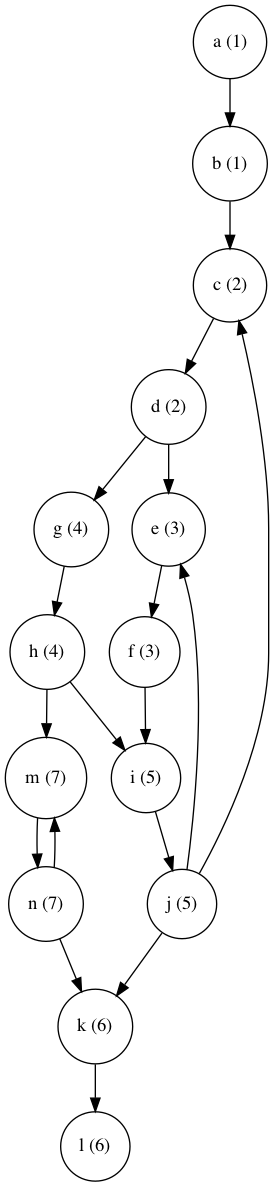

In [24]:
# The associated graph with mappings expanded of this instance is:
graph( allen.graph )

## Simple Path Infer from Allen Type Graph

In [25]:
sigma = Alphabet()
allen = AllenLog( path_length=2, N=30, loop_repeats=2, alphabet=sigma )

%time inferred_paths = infer_paths_by_adding_graphs(allen.mapped_log)

CPU times: user 799 ms, sys: 5.31 ms, total: 805 ms
Wall time: 807 ms


In [26]:
# Knowing that the invariant paths were given
allen.paths

[['a', 'b'],
 ['c', 'd'],
 ['e', 'f'],
 ['g', 'h'],
 ['i', 'j'],
 ['k', 'l'],
 ['m', 'n']]

In [27]:
# Are each allen.paths in any of the inferred paths?  True is happiness
all( [ any( [ 
        set(A).issubset( set(P[1]) ) for A in allen.paths 
    ] )  for P in inferred_paths
] )

True

In [28]:
# Below is the set of inferred paths.
inferred_paths

[(431, ['c', 'd']),
 (690, ['m', 'n']),
 (55, ['e', 'f']),
 (337, ['i', 'j']),
 (90, ['a', 'b', 'k', 'l']),
 (374, ['g', 'h'])]